# Assignment 2 Part 1 Questions

1. A data warehouse for a music streaming company consists of the dimensions song, user, time (time and date of when the user listened to a song), and the two measures count (how many times a user listened to the song) and fee (fee paid by the streaming company to the artist every time a user listens to that song). 
  1. Draw a schema diagram for the above data warehouse using a star schema.
  2. Starting with the base cuboid [time, user, song], what specific OLAP operations should be performed in order to list the total fee collected for a given song for a given month of a given year (e.g. October 2021)?
  3. Assume that the time dimension has 4 levels: day, month, quarter, year; and that the song and user dimensions both have 1 level (not including the virtual level 'all'). How many cuboids will this cube contain (including the base and apex cuboids)?
  

2. Suppose that a car rental company has a data warehouse that holds record ID lists of vehicles in terms of brands (Audi, Ford, Mini) and store branches (Tower Hamlets, Newham, Hackney). Each record consists of a combination of vehicle brand and branch, and records for all combinations exist. We would like to index the OLAP data using bitmap indices. Write down the *base table* for record IDs, and the corresponding *bitmap index table* for vehicle brand.
  

3. Using the same CSV file and data cube in the above lab tutorial, modify the "tutorial_model.json" file to include aggregate measures for the minimum and maximum amount in the data cube. Using these implemented aggregate measures, produce the values for the minimum and maximum amount in the data per year. Make sure to show your workings in the PDF report. You can read the [Cubes package documentation](https://readthedocs.org/projects/cubes/downloads/pdf/latest/) for assistance in this task.


4. Using the CSV file "country-income.csv" (found in the week 5 supplementary lab documents), perform the following:
  1. Load the CSV file using Cubes, create a JSON file for the data cube model, and create a data cube for the data. Use as dimensions the region, age, and online shopper fields. Use as measure the income. Define aggregate functions in the data cube model for the total, average, minimum, and maximum income. In your PDF report, show the relevant scripts and files created.
  2. Using the created data cube and data cube model, produce aggregate results for: the whole data cube; results per region; results per online shopping activity; and results for all people aged between 40 and 50.

## Question 1A

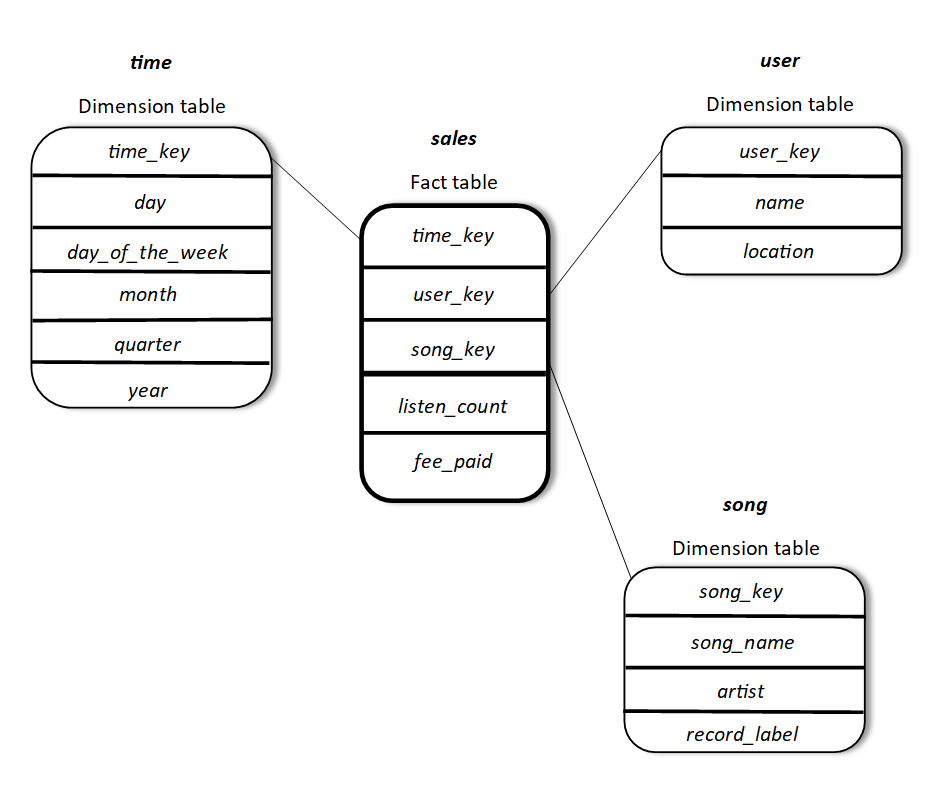

## Question 1B

* A roll-up operation could be performed to group the data by month (from day).
* A slice operation could be used to select the month (e.g. October 2021)
* Finally we can roll-up on individual users to aggregate data for all users

## Question 1C

For an n-dimensional data cube, the total number of cuboids that can be generated can be computed as follows:

Total number of cuboids = $\prod_{i=1}^{n}(Li + 1)$

* Including the virtual level all, the time dimension will have a total of five conceptual levels
* The song and user dimensions have a total of two conceptual levels each (including all)
* Therefore, the total number of cuboids would be the product of $5\times2\times2 = 20$ cuboids


## Question 2

Base table:

| RID| Brand| Store branch | 
|:---|:-----|-----:|
|R1  | Audi |Tower Hamlets|  
|R2  | Ford | Tower Hamlets | 
|R3  | Mini | Tower Hamlets |
|R4  | Audi |Hackney|  
|R5  | Ford | Hackney | 
|R6  | Mini | Hackney |
|R7  | Audi |Newham|  
|R8  | Ford | Newham | 
|R9  | Mini |Newham|

Vehicle brand bitmap index table:

| RID| Audi| Ford | Mini |
|:---|:-----|:-----|:---|
|R1  | 1 | 0 | 0 |
|R2  | 0 | 1 | 0 |
|R3  | 0 | 0 | 1 |
|R4  | 1 | 0 | 0 |
|R5  | 0 | 1 | 0 |
|R6  | 0 | 0 | 1 |
|R7  | 1 | 0 | 0 |
|R8  | 0 | 1 | 0 |
|R9  | 0 | 0 | 1 |



## Question 3

The "tutorial_model.json" was modified as follows, to include the aggregate measures for the minimum and maximum amount in the data cube.

<code>
{
    "dimensions": [
        {
         "name":"item",
         "levels": [
                {
                    "name":"category",
                    "label":"Category",
                    "attributes": ["category", "category_label"]
                },
                {
                    "name":"subcategory",
                    "label":"Sub-category",
                    "attributes": ["subcategory", "subcategory_label"]
                },
                {
                    "name":"line_item",
                    "label":"Line Item",
                    "attributes": ["line_item"]
                }
            ]
        },
        {"name":"year", "role": "time"}
    ],
    "cubes": [
        {
            "name": "ibrd_balance",
            "dimensions": ["item", "year"],
            "measures": [{"name":"amount", "label":"Amount"}],
            "aggregates": [
                    {
                        "name": "amount_sum",
                        "function": "sum",
                        "measure": "amount"
                    },
                    {
                        "name": "record_count",
                        "function": "count"
                    },
                    {
                        "name": "amount_min",
                        "function": "min",
                        "measure": "amount"
                    },
                    {
                        "name": "amount_max",
                        "function": "max",
                        "measure": "amount"
                    }
                ],
            "mappings": {
                          "item.line_item": "line_item",
                          "item.subcategory": "subcategory",
                          "item.subcategory_label": "subcategory_label",
                          "item.category": "category",
                          "item.category_label": "category_label"
                         },
            "info": {
                "min_date": "2010-01-01",
                "max_date": "2010-12-31"
            }
        }
    ]
}
</code>

Minimum and maximum amount in the data per year:

In [1]:
from sqlalchemy import create_engine
from cubes.tutorial.sql import create_table_from_csv
from cubes import Workspace
import cubes as cubes

engine = create_engine('sqlite:///data.sqlite')
create_table_from_csv(engine,
                      "IBRD_Balance_Sheet__FY2010.csv",
                      table_name="ibrd_balance",
                      fields=[
                          ("category", "string"),
                          ("category_label", "string"),
                          ("subcategory", "string"),
                          ("subcategory_label", "string"),
                          ("line_item", "string"),
                          ("year", "integer"),
                          ("amount", "integer")],
                      create_id=True
                     )

workspace = Workspace()
workspace.register_default_store("sql", url="sqlite:///data.sqlite")

workspace.import_model("tutorial_model.json")

cube = workspace.cube("ibrd_balance")
cube

browser = workspace.browser(cube)

result = browser.aggregate(drilldown=["year"])
for record in result:
    print(record)

{'year': 2009, 'amount_sum': 550840, 'record_count': 31, 'amount_min': -1683, 'amount_max': 110040}
{'year': 2010, 'amount_sum': 566020, 'record_count': 31, 'amount_min': -3043, 'amount_max': 128577}


## Question 4A

In [2]:
create_table_from_csv(engine,
                      "country-income.csv",
                      table_name="country-income",
                      fields=[
                          ("region", "string"),
                          ("age", "integer"),
                          ("income", "integer"),
                          ("online_shopper", "string")],
                      create_id=True
                     )

workspace.import_model("country_income.json")

cube = workspace.cube("country-income")
cube

browser = workspace.browser(cube)

The "country_income.json" file contains the following:

<code>
{
    "dimensions": [
        {
			"name":"region",
			"label": "Region"
		},
		{
			"name":"age",
			"label":"Age"
		},
		{
			"name":"online_shopper",
			"label":"Online_Shopper"
		}
    ],
    "cubes": [
        {
            "name": "country-income",
            "dimensions": ["region", "age", "online_shopper"],
            "measures": [{"name":"income", "label":"Income"}],
            "aggregates": [
                    {
                        "name": "income_sum",
                        "function": "sum",
                        "measure": "income"
                    },
                    {
                        "name": "income_min",
                        "function": "min",
                        "measure": "income"
                    },
                    {
                        "name": "income_max",
                        "function": "max",
                        "measure": "income"
                    },
                    {
                        "name": "income_avg",
                        "function": "avg",
                        "measure": "income"
                    }
                ]
        }
    ]
}
    
</code>

## Question 4B

Aggregate results for the data cube:

In [3]:
result = browser.aggregate()
print(result.summary)

{'income_sum': 768200, 'income_min': 57600, 'income_max': 99600, 'income_avg': 76820.0}


Aggregate results for per region:

In [4]:
result = browser.aggregate(drilldown=["region"])
for record in result:
    print(record)

{'region': 'Brazil', 'income_sum': 193200, 'income_min': 57600, 'income_max': 73200, 'income_avg': 64400.0}
{'region': 'India', 'income_sum': 331200, 'income_min': 69600, 'income_max': 94800, 'income_avg': 82800.0}
{'region': 'USA', 'income_sum': 243800, 'income_min': 64800, 'income_max': 99600, 'income_avg': 81266.66666666667}


Aggregate results per online shopping activity:

In [5]:
result = browser.aggregate(drilldown=["online_shopper"])
for record in result:
    print(record)

{'online_shopper': 'No', 'income_sum': 386400, 'income_min': 62400, 'income_max': 99600, 'income_avg': 77280.0}
{'online_shopper': 'Yes', 'income_sum': 381800, 'income_min': 57600, 'income_max': 94800, 'income_avg': 76360.0}


Aggregate results for all people aged between 40 and 50:

In [6]:
cuts = [cubes.RangeCut("age", ["40"], ["50"])]
cell = cubes.Cell(cube, cuts)
result = browser.aggregate(cell, drilldown=["age"])
print(result.summary)

{'income_sum': 451400, 'income_min': 62400, 'income_max': 86400, 'income_avg': 75233.33333333333}


# Assignment 2 Part 2 Questions

1. Consider a dataset $\mathcal{D}$ that contains only two observations $\mathbf{x}_{1} = (1, -1)$ and $\mathbf{x}_2 = (-1, 1)$. Suppose that the class of the first observation is $y_1 = 0$ and that the class of the second observation is $y_2 = 1$. How would a 1-nearest neighbour classifier based on the Euclidean distance classify the observation $\mathbf{x} = (-2, 3)$? What are the distances between this new observation and each observation in the dataset?
2. Consider a dataset $\mathcal{D}$ that only contains observations of two different classes. Explain why a $k$-nearest neighbour classifier does not need a tie-breaking policy when $k$ is odd.
3. Explain why a classifier that obtains an accuracy of $99.9\%$ can be terrible for some datasets.
4. Consider a classifier tasked with predicting whether an observation belongs to class $y$ (positive class). Suppose that this classifier has precision $1.0$ and recall $0.1$ on a test dataset. If this classifier predicts that an observation does not belong to class $y$, should it be trusted? Should it be trusted if it predicts that the observation belongs to class $y$?
5. Based on the confusion matrix shown in this lab notebook, what is the pair of classes that is most confusing for the $1$-nearest neighbour classifier trained in the previous sections?
6. Train a support vector machine classifier using the same (subsampled) training dataset used in the previous sections and compute its accuracy on the corresponding test dataset. You can use the default hyperparameters for the class ``SVC`` from ``sklearn.svm``. Show the code in the report.
7. Using the same (subsampled) training dataset used in the previous sections, employ ``GridSearchCV`` to find the best hyperparameter settings based on 5-fold cross-validation for a ``RandomForestClassifier``. Consider ``n_estimators`` $ \in \{ 50, 100, 200\}$ and ``max_features`` $ \in \{0.1, 0.25\}$. Use the default values for the remaining hyperparameters. Compute the accuracy of the best model on the corresponding test dataset. Show the code in the report.


## Question 1


The Euclidean distance of $x$ from $x_1$ is $ \sqrt { (1 - -2)^{2} + (-1-3)^{2} } = \sqrt { 3^{2} + -4^{2} } = \sqrt { 25 } = 5$

The Euclidean distance of $x$ from $x_2$ is $ \sqrt { (-1 - -2)^{2} + (1 - 3)^{2} } = \sqrt { 1^{2} + -2^{2} } = \sqrt { 5 } = 2.24$ (to two decimal places)

Therefore, we can see that point $x$ is closer to $x_2$ and would be assigned a label of $1$ based on the 1-nearest neighbour classifier.

## Question 2

The $k$-nearest neighbour is works based on the assumption that observations within the same class exist within close proximity. It considers $k$ nearest observations (based on distance) and classifies a new observation based on the most common class in the nearest observation(s).

For example, if $k$ was set to $5$ (an odd number) and there were two classes (0 and 1), a new observation would be classified based on the majority class of the 5 nearest observations. Assuming that 3 of the 5 nearest neighbours were in class 0, then our new observation would also be put in class 0.

Using the same example, if we changed $k$ to $6$ and 3 of the 6 nearest neighbours were in class 0, there would also be 3 in class 1. Therefore, there would be no majority and a tie-breaking policy would be required.

We can see that when $k$ is odd and there are 2 classes, there would be a majority class and a tie-breaking policy would not be required. In other words, an odd $k$ divided by 2 would cause a remainder, thus leading to a majority class.

## Question 3

The accuracy is the fraction of observations in a dataset that are classified correctly. Whilst an accuracy of 99.9% may seem desirable, it does not consider the effect of class imbalance. This could occur if the main class of interest was rare. For example, if a classifier was trained to classify the diagnosis of a rare medical condition (with two outcomes - positive or negative), then an accuracy of 99.9% may only refer to correct classification of the negative class. In this case, misclassification of the positive class could result in great costs and would mean that the classifier is not very useful, so other measures could be used to assess the recognition of tuples in different classes.

## Question 4

A precision (measure of exactness) of 1 would imply that every tuple within a specific class actually belongs to that class (i.e. there were no false positives). However, this does not provide any information on the misclassifications of that class, i.e. the number of false negatives.

On the other hand, recall is a measure of completeness which indicates the percentage of positive tuples that were truly positive. It does not provide information on how many tuples were incorrectly labeled as being in that class (false positives). A low recall value of 0.1 suggests that a there were a lot of samples incorrectly classified as being in the negative class. We can see that there is an inverse relationship between precision and recall. 

If $y$ is the positive class and the classifier predicts that an observation does not belong to this class, then the low recall suggests that there were a lot of false negatives (so we are not confident in detecting positive observations), so this information cannot be trusted.

If $y$ is the positive class and the classifier predicts that an observation belongs to this class, then we can trust it (have high confidence in positive predictions) as the precision is 1 - there are no false positives.



## Question 5

From the confusion matrix, we can see that class 9 is the most confusing for the classifier as it has the second lowest precision and the lowest recall. Within this class, most of the misclassifications arise when a sample that is truly in class 9 is misclassified as class 4. Therefore, the most confusing pair of classes is 4 and 9.

## Question 6

In [7]:
import gzip
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Selecting the training data from the original dataset
f = gzip.open('data/mnist.pkl.gz', 'rb')
X, y = pickle.load(f, encoding='latin1')[0]
f.close()

# Subsampling
sample_size = 2000
X, y = X[:sample_size], y[:sample_size]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)
print('Test dataset accuracy for the support vector machine classifier: {0}.'
      .format(svc.score(X_test, y_test)))

Test dataset accuracy for the support vector machine classifier: 0.9275.


## Question 7

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [50, 100, 200], 'max_features': [0.1, 0.25]}

rfc = RandomForestClassifier()
rfc_cv = GridSearchCV(rfc, parameters, cv=5)
rfc_cv.fit(X_train, y_train)
print('Best hyperparameter setting: {0}.'
      .format(rfc_cv.best_estimator_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'
      .format(rfc_cv.best_score_))
print('Test dataset accuracy of best hyperparameter setting: {0}.'
      .format(rfc_cv.score(X_test, y_test)))

Best hyperparameter setting: RandomForestClassifier(max_features=0.1, n_estimators=200).
Average accuracy across folds of best hyperparameter setting: 0.909375.
Test dataset accuracy of best hyperparameter setting: 0.91.
